# This ipynb is used to get and clean data for Purdue University,West Lafayette, Indiana

In [1]:
import networkx as nx
import osmnx as ox
import fiona
import math
import json

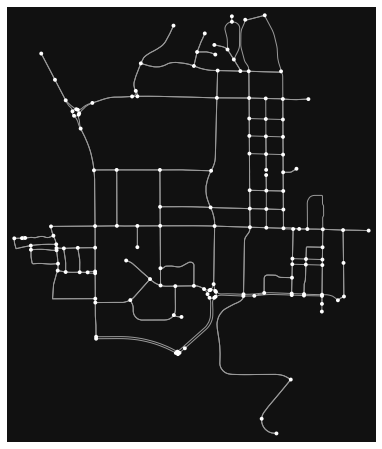

In [2]:
G = ox.graph_from_place("Purdue University,West Lafayette, Indiana, USA", network_type="drive")
fig, ax = ox.plot_graph(G)

In [3]:
place = "Purdue University,West Lafayette, Indiana"
tags = {"building": True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(427, 62)

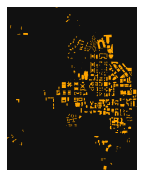

In [4]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

In [5]:
ox.save_graphml(G, filepath="./wl.graphml")

# Here, please run the C++ file titled graph-parser.cpp (compiled as g++ graph-parser-wl.cpp and then run as ./a.out) .

In [6]:
cc = json.loads(gdf.to_json())
with open("sample_2.json", "w") as outfile:
     json_object = json.dump(cc, outfile, indent=4, sort_keys=True)
 

In [7]:
f = open("sample_2.json")

cx_try = json.load(f)

In [8]:
new_json = []
for build_obj in cx_try["features"]:
    new_obj = {}
    if build_obj['geometry']['type'] == 'Point':
        new_obj['coordinates'] = build_obj['geometry']['coordinates']
    else:
        new_obj['coordinates'] = build_obj['geometry']['coordinates'][0][0]
    
    new_obj['building'] = build_obj['properties']['building']
    new_obj['name'] =build_obj['properties']['name']
    new_json.append(new_obj)

In [9]:
edges = {}
with open('edge.txt') as file:
    edge = {}
    for line in file:
        if 'tid' in line:
            edge['tid'] = int(line.split(': ')[1].strip())
        elif 'source_coords' in line:
            edge['source_coords'] = tuple(map(float, line.split(': ')[1].strip().split(',')))
        elif 'target_coords' in line:
            edge['target_coords'] = tuple(map(float, line.split(': ')[1].strip().split(',')))
        elif '---next---' in line:
            edges[edge['tid']] = {'source_coords': edge['source_coords'], 'target_coords': edge['target_coords']}
            edge = {}

# print(edges)

In [10]:
with open('tid_offset.txt', 'r') as file:
    lines = file.readlines()

second_last_line = lines[-1].strip()  # Get the second last line and remove leading/trailing white space
last_tid = int(second_last_line.split()[0])  # Get the first number on the line as an integer

print(last_tid)

317


In [11]:
from tqdm import tqdm

In [12]:
def find_closest_edge(building, edges):
    min_distance = math.inf
    closest_edge = None
    for tid, edge in edges.items():
        source_coords = edge['source_coords']
        target_coords = edge['target_coords']
        distance_to_source = math.sqrt((building['coordinates'][0] - source_coords[0])**2 + (building['coordinates'][1] - source_coords[1])**2)
        distance_to_target = math.sqrt((building['coordinates'][0] - target_coords[0])**2 + (building['coordinates'][1] - target_coords[1])**2)
        if distance_to_source < min_distance:
            min_distance = distance_to_source
            closest_edge = tid
        if distance_to_target < min_distance:
            min_distance = distance_to_target
            closest_edge = tid
    return closest_edge

# Example usage
tid_building = last_tid + 1
for building in tqdm(new_json):
    closest_edge = find_closest_edge(building, edges)
    building['closest_tid'] = closest_edge
    building['tid'] = tid_building
    tid_building = tid_building + 1
#     print(building)

100%|███████████████████████████████████████| 427/427 [00:00<00:00, 3919.02it/s]


In [13]:
with open("edge.txt", 'a') as file:
    for building in new_json:
        file.write(f"tid: {building['tid']}\n")
        file.write(f"length: NA\n")
        file.write(f"source:  \n")
        file.write(f"target:  \n")
        file.write(f"source_coords: {building['coordinates'][0]}, {building['coordinates'][1]}\n")
        file.write(f"target_coords: {building['coordinates'][0]}, {building['coordinates'][1]}\n")
        file.write(f"name: {building['name']}\n")
        file.write(f"type: {building['building']}\n")
        file.write(f"neighbours: {building['closest_tid']}\n")
        file.write("---next---\n")

# Next, run g++ poi-parser-wl.cpp and ./a.out